Clean images

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import astropy as astro
#from scipy import stats
#from scipy.optimize import curve_fit

from astropy.io import fits
from astropy.wcs import WCS

!pip install --upgrade pip
!pip install photutils

from photutils.detection import DAOStarFinder
from astropy.stats import mad_std

from astropy.stats import sigma_clipped_stats
from astropy.stats import SigmaClip

from astropy import units as u
from photutils.background import Background2D, MedianBackground
from photutils.aperture import aperture_photometry, CircularAnnulus, CircularAperture

import csv

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [9]:
bias = 'bias.fits'
hdu = fits.open(bias)[0]
bias_image = hdu.data
hdr = hdu.header

flat = 'rflat.fits'
hdu = fits.open(flat)[0]
flat_image = hdu.data
hdr = hdu.header

norm = flat_image.mean()
print(norm)
flat_normed = flat_image/norm

0.9547995


SIMPLE  =                    T / Fits standard                                  BITPIX  =                  -32 / Bits per pixel                                 NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 1365 / Axis length                                    NAXIS2  =                 1365 / Axis length                                    EXTEND  =                    T / File may contain extensions                    ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        DATE    = '2023-09-24T03:19:01' / Date FITS file was generated                  IRAF-TLM= '2023-09-24T03:19:49' / Time of last modification                     OBJECT  = 'A2199   '           / Name of the object observed                    CCDSUM  = '3 3     '           / CCD pixel summing                              CCDBIN1 =                    3 / Binning factor along axis 1                    CCDBIN2 =                    3 / Binning

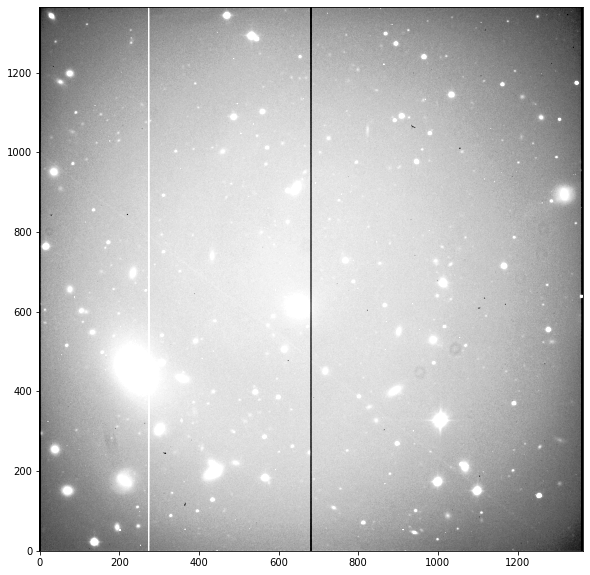

In [15]:
filename = "a2199.0007.fits"
hdu = fits.open(filename)[0]
image = hdu.data
hdr = hdu.header
print(hdr)

#image = (image - bias_image) / flat_image
plt.figure(figsize=(10, 10))
plt.imshow(image, origin='lower', cmap='Greys_r', vmin=1000, vmax=1500)

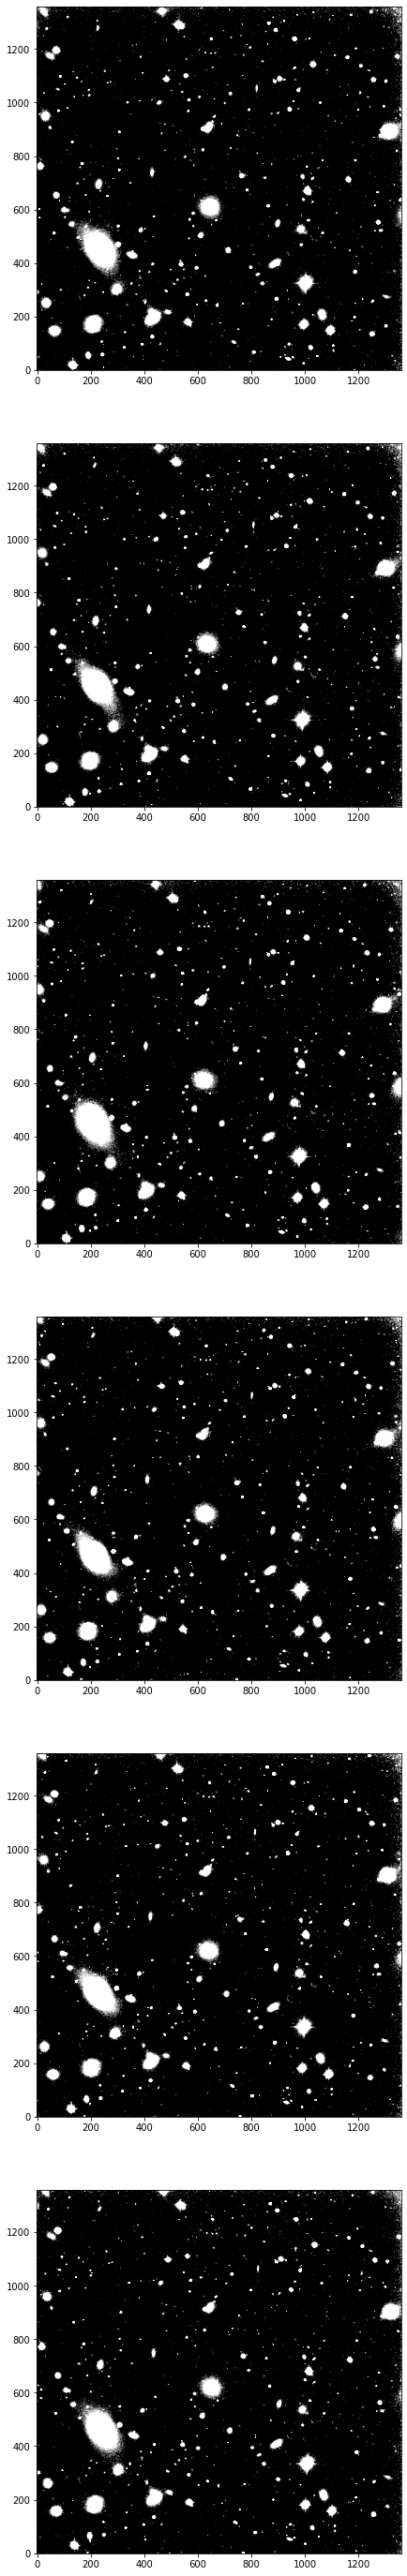

In [7]:
a2199_r_images = []
for i in range(7, 13):
    # open file
    filename = f"a2199.00{i//10}{i%10}.fits"
    hdu = fits.open(filename)[0]
    image = hdu.data
    hdr = hdu.header
    
    # debias
    image = (image - bias_image) / flat_normed
    
    # bad columns handling
    image[:, 275] = 0.5 * (image[:, 274] + image[:, 276])
    image[:, 682] = 0.5 * (image[:, 681] + image[:, 683])
    
    # crop image
    image = image[4:1364, 4:1364]
    
    #substract background
    mean, median, std = sigma_clipped_stats(image, sigma=3.0)
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = MedianBackground()
    bkg = Background2D(image, (50, 50), filter_size=(3,3),sigma_clip=sigma_clip,bkg_estimator=bkg_estimator)
    #plt.imshow(bkg.background, origin='lower', cmap='Greys_r',interpolation='nearest')
    image = image - bkg.background
    a2199_r_images.append(image)
    
    fits.writeto(f"a2199.000{i-6}.r.clean.fits", image, hdr, overwrite=True)


fig, axs = plt.subplots(6, 1, figsize = (50, 50))
for i in range(6):
    axs[i].imshow(a2199_r_images[i], origin='lower', cmap='Greys_r', vmin=10, vmax=50)
plt.show()
